In [20]:
import requests, zipfile, os
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

Downlad dataset

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

In [3]:
DATA_FILE = "hotel_bookings.csv"

df_hotels = pd.read_csv(DATA_FILE)
df_hotels

hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

       arrival_date_month  arrival_date_week_number  \
0                    July                        27   
1                    July                        27   
2                    July                        27   
3                    July                        27   
4                    July                        27   
...                   ...                       ...   
119385             August                        35   
119386             August                        35   
119387             August                        35   
119388             August                        35   
119389             August                        35   

        arrival_date_day_of_month  stays_in_weekend_nights  \
0                               1                        0   
1                               1                        0   
2                               1                        0   
3                               1                        0   
4                               1                        0   
...                           ...                      ...   
119385                         30                        2   
119386                         31                        2   
119387                         31                        2   
119388                         31                        2   
119389                         29                        2   

        stays_in_week_nights  adults  ...  deposit_type  agent company  \
0                          0       2  ...    No Deposit    NaN     NaN   
1                          0       2  ...    No Deposit    NaN     NaN   
2                          1       1  ...    No Deposit    NaN     NaN   
3                          1       1  ...    No Deposit  304.0     NaN   
4                          2       2  ...    No Deposit  240.0     NaN   
...                      ...     ...  ...           ...    ...     ...   
119385                     5       2  ...    No Deposit  394.0     NaN   
119386                     5       3  ...    No Deposit    9.0     NaN   
119387                     5       2  ...    No Deposit    9.0     NaN   
119388                     5       2  ...    No Deposit   89.0     NaN   
119389                     7       2  ...    No Deposit    9.0     NaN   

       days_in_waiting_list customer_type     adr  \
0                         0     Transient    0.00   
1                         0     Transient    0.00   
2                         0     Transient   75.00   
3                         0     Transient   75.00   
4                         0     Transient   98.00   
...                     ...           ...     ...   
119385                    0     Transient   96.14   
119386                    0     Transient  225.43   
119387                    0     Transient  157.71   
119388                    0     Transient  104.40   
119389                    0     Transient  151.20   

        required_car_parking_spaces  total_of_special_requests  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   
3             

## Exploratoy Data Analysis

In [ ]:
px.bar(df_hotels.groupby("hotel").is_canceled.sum(),
       title="Number of cancellations per Hotel type",
       labels={'hotel': 'Hotel type', 'value': '# of cancellations'})


In [ ]:
fig = px.bar(df_hotels.groupby("assigned_room_type").sum().is_canceled, 
             title="Number of cancellations per room type",
             labels={'assigned_room_type': "Assigned room type", 'value': "# of cancellations"})

fig.show()

In [ ]:
px.box(df_hotels.days_in_waiting_list, title="Distribution of the Days in waiting list",
        labels={'value': "Number of days in waiting list"})

In [ ]:
px.histogram(df_hotels, x='deposit_type', color='is_canceled',
             title="Cancellations per deposit type",
             labels={'deposit_type': "Deposit Type", 'count': '# of Cancellations'})

In [ ]:
px.histogram(df_hotels, x='arrival_date_month', 
             title='Hotel arrivals per month', 
             labels={'arrival_date_month': 'Month of arrival to the hotel', 'count': '# of arrivals'})


## Preprocessing

In [4]:
missing_cols = df_hotels.isna().sum()
missing_cols[missing_cols > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [5]:
# We drop 'company' because it's mostly null values (94%)
df_hotels.drop('company', inplace=True, axis=1)

In [6]:
# The country feature is missing less than 1%, we'll replace missing values with the most common country.
df_hotels['country'] = df_hotels['country'].fillna(df_hotels['country'].mode().index[0])

# The paper stated that Null values for agent just means that there was no agent involved, so we impute with 0
df_hotels['agent'] = df_hotels['agent'].fillna(0)

# The children feature is missing just 4 values, so filling with 0 is reasonable.
df_hotels['children'] = df_hotels['children'].fillna(0)

In [7]:
# We merge the 'children' and the 'babies' features since i don't see any difference
df_hotels['all_children'] = df_hotels['children'] + df_hotels['babies']
df_hotels.drop('children', inplace=True, axis=1)
df_hotels.drop('babies', inplace=True, axis=1)

In [8]:
# 'arrival_date_month' names converted to the numbers
df_hotels['arrival_date_month'].replace({
        'January' : '1',
        'February' : '2',
        'March' : '3',
        'April' : '4',
        'May' : '5',
        'June' : '6',
        'July' : '7',
        'August' : '8',
        'September' : '9', 
        'October' : '10',
        'November' : '11',
        'December' : '12'}, inplace=True)

In [9]:
# Change data types
df_hotels['agent'] = df_hotels['agent'].astype(int)
df_hotels['country'] = df_hotels['country'].astype(str)

In [10]:
pd.DataFrame({'Feature': col, '# Unique Values': df_hotels[col].nunique()} for col in df_hotels.select_dtypes(object).columns)

Feature  # Unique Values
0                     hotel                2
1        arrival_date_month               12
2                      meal                5
3                   country              178
4            market_segment                8
5      distribution_channel                5
6        reserved_room_type               10
7        assigned_room_type               12
8              deposit_type                3
9             customer_type                4
10       reservation_status                3
11  reservation_status_date              926

In [11]:
df_hotels['reservation_status_date'] = pd.to_datetime(df_hotels['reservation_status_date'])

df_hotels['reservation_year'] = df_hotels['reservation_status_date'].dt.year
df_hotels['reservation_month'] = df_hotels['reservation_status_date'].dt.month
df_hotels['reservation_day'] = df_hotels['reservation_status_date'].dt.day

df_hotels.drop(['reservation_status_date'], axis=1, inplace=True)


Apply categorical label encoding to all categorical features

In [12]:
le = LabelEncoder()
for col in df_hotels.select_dtypes(object).columns:
    print("Applying categorical label encoding to", col)
    df_hotels[col] = le.fit_transform(df_hotels[col])

Applying categorical label encoding to hotel
Applying categorical label encoding to arrival_date_month
Applying categorical label encoding to meal
Applying categorical label encoding to country
Applying categorical label encoding to market_segment
Applying categorical label encoding to distribution_channel
Applying categorical label encoding to reserved_room_type
Applying categorical label encoding to assigned_room_type
Applying categorical label encoding to deposit_type
Applying categorical label encoding to customer_type
Applying categorical label encoding to reservation_status


In [13]:
df_hotels.head()


hotel  is_canceled  lead_time  arrival_date_year  arrival_date_month  \
0      1            0        342               2015                   9   
1      1            0        737               2015                   9   
2      1            0          7               2015                   9   
3      1            0         13               2015                   9   
4      1            0         14               2015                   9   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0                     0       2  ...   
2                        0                     1       1  ...   
3                        0                     1       1  ...   
4                        0                     2       2  ...   

   days_in_waiting_list  customer_type   adr  required_car_parking_spaces  \
0                     0              2   0.0                            0   
1                     0              2   0.0                            0   
2                     0              2  75.0                            0   
3                     0              2  75.0                            0   
4                     0              2  98.0                            0   

   total_of_special_requests  reservation_status  all_children  \
0                          0                   1           0.0   
1                          0                   1           0.0   
2                          0                   1           0.0   
3                          0                   1           0.0   
4                          1                   1           0.0   

   reservation_year  reservation_month  reservation_day  
0              2015                  7                1  
1              2015                  7                1  
2              2015                  7                2  
3              2015                  7                2  
4              2015                  7                3  

[5 rows x 32 columns]

In [14]:
categorical_columns = [ 'hotel','is_canceled','arrival_date_month','meal',
                        'country','market_segment','distribution_channel', 
                        'is_repeated_guest', 'reserved_room_type',
                        'assigned_room_type','deposit_type','agent',
                        'customer_type', 'reservation_status', 'reservation_month', 'reservation_day'
                      ]

hotel_data_categorical = df_hotels[categorical_columns]
hotel_data_numerical = df_hotels.drop(set(categorical_columns)-{'is_canceled'}, axis=1)


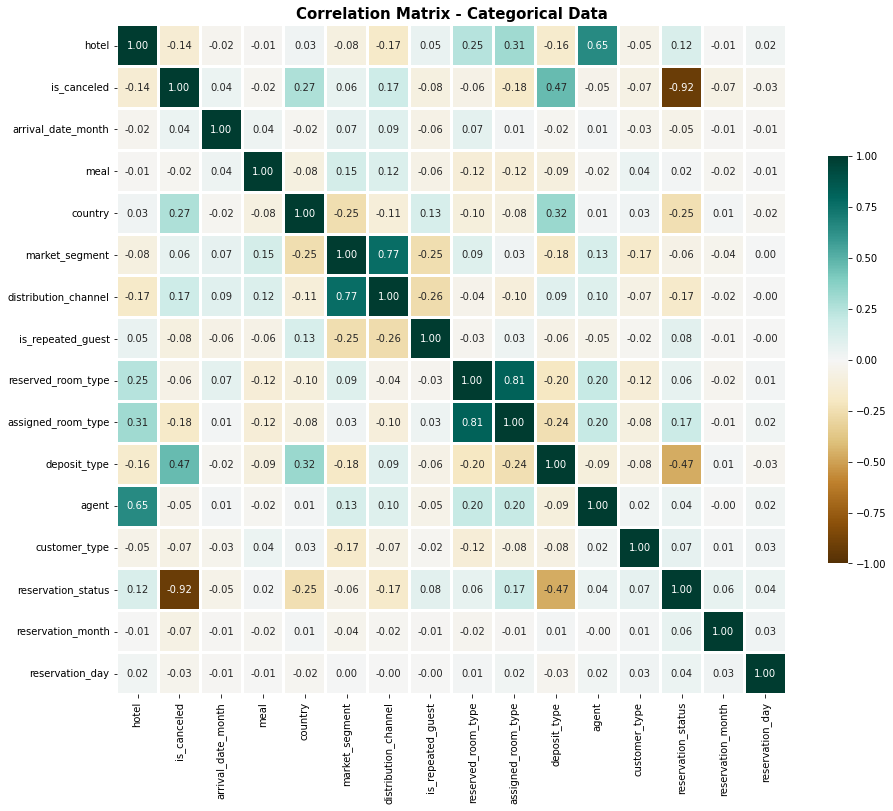

In [15]:
def draw_corr_matrix(data: pd.DataFrame, title):
  plt.figure(figsize=(15,15))
  corr = data.corr()
  sns.heatmap(corr, annot=True, cmap='BrBG', vmin=-1, vmax=1, center= 0,fmt=".2f",
              square=True, linewidths=2, cbar_kws={"shrink": .5})
  plt.title(title,size=15, weight='bold')

draw_corr_matrix(hotel_data_categorical, "Correlation Matrix - Categorical Data")

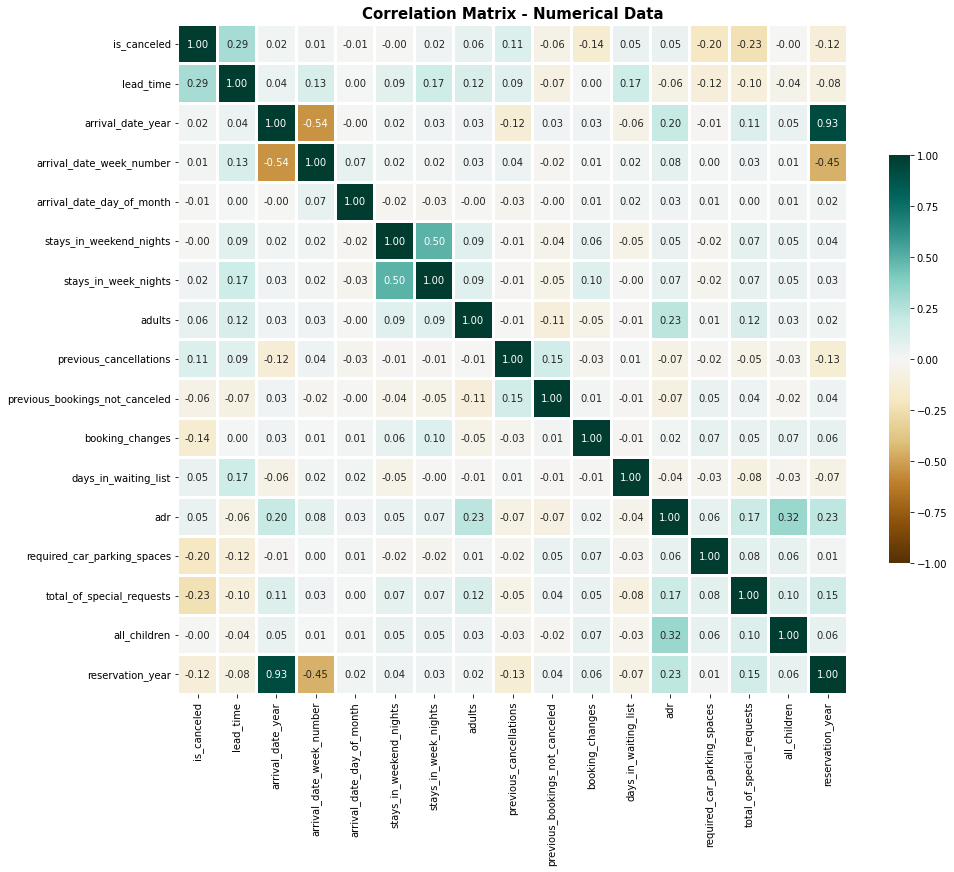

In [16]:
draw_corr_matrix(hotel_data_numerical, "Correlation Matrix - Numerical Data")

In [17]:
# Remove highly coorelated features
df_hotels = df_hotels.drop(['reservation_status'], axis=1)
df_hotels.shape

(119390, 31)

## Model training

In [18]:
y = df_hotels['is_canceled']
X = df_hotels.drop('is_canceled', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
print(f"Training on {X_train.shape[0]} entries with {X_train.shape[1]} features")
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print("Full Decision Tree accuracy on test:", dtc.score(X_test, y_test))

Training on 95512 entries with 30 features
Full Decision Tree accuracy on test: 0.9444677108635564


In [ ]:
pd.DataFrame(index=X.columns, data=dtc.feature_importances_,
             columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)


Feature Importance
deposit_type                              0.230806
arrival_date_week_number                  0.101406
reservation_month                         0.084261
reservation_day                           0.067383
market_segment                            0.059496
lead_time                                 0.058291
country                                   0.048819
arrival_date_day_of_month                 0.046819
total_of_special_requests                 0.045365
arrival_date_month                        0.039604
agent                                     0.039583
reservation_year                          0.025127
adr                                       0.023382
previous_cancellations                    0.023182
arrival_date_year                         0.022875
required_car_parking_spaces               0.020093
stays_in_week_nights                      0.011504
customer_type                             0.009649
booking_changes                           0.008628
assigned_room_type                        0.005839
stays_in_weekend_nights                   0.005153
previous_bookings_not_canceled            0.004476
adults                                    0.004158
meal                                      0.004030
reserved_room_type                        0.002746
all_children                              0.002044
distribution_channel                      0.001895
hotel                                     0.001323
is_repeated_guest                         0.001083
days_in_waiting_list                      0.000982

In [ ]:
print(f"Training full Random Forest model...")
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

print(f"Random Forest accuracy: {rfc.score(X_test, y_test)}")


Training full Random Forest model...
Random Forest accuracy: 0.9594605913393082


In [ ]:
print(f"Training default AdaBoost model...")
ada_boost_classifier = AdaBoostClassifier()
ada_boost_classifier.fit(X_train, y_train)

print(f"AdaBoost accuracy: {ada_boost_classifier.score(X_test, y_test)}")


Training default AdaBoost model...
AdaBoost accuracy: 0.8486891699472318


In [ ]:
print(f"Training Bagging model...")
bagging_model = BaggingClassifier()
bagging_model.fit(X_train, y_train)

print(f"Bagging accuracy: {bagging_model.score(X_test, y_test)}")


Training Bagging model...
Bagging accuracy: 0.9638160649970684


In [ ]:
print(f"Training LogisticRegression model...")
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

print(f"Logistic Regression accuracy: {logistic_model.score(X_test, y_test)}")


Training LogisticRegression model...
Logistic Regression accuracy: 0.7326828042549627


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [35]:
rf_score_train = []
rf_score_test = []

trees_range = np.arange(1, 50, 5)

for trees in trees_range:
    print(trees)
    classifier = RandomForestClassifier(random_state=0, n_estimators=trees)
    classifier.fit(X_train, y_train)

    rf_score_train.append(classifier.score(X_train, y_train))
    rf_score_test.append(classifier.score(X_test, y_test))

rf_score_test

1
6
11
16
21
26
31
36
41
46


[0.8912806767735991,
 0.9396096825529776,
 0.9504564871429768,
 0.9528436217438646,
 0.9562358656503894,
 0.956277745204791,
 0.9583298433704666,
 0.9581204455984589,
 0.9582042047072619,
 0.9580785660440573]

In [36]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=trees_range,
    y=rf_score_train,
    name="Acc on Train"
))

fig.add_trace(go.Line(
    x=trees_range,
    y=rf_score_test,
    name="Acc on Test"
))


fig.update_layout(
    title="Random forest train/test accuracy as a function of number of trees",
    xaxis_title="# of trees",
    yaxis_title="Accuracy"
)

fig.show()


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [37]:
adaboost_score_train = []
adaboost_score_test = []

n_trees =  [5, 10, 20, 50, 100, 500, 1000, 5000]

for trees in n_trees:
    print(trees)
    base_estimator = DecisionTreeClassifier(max_depth=1)
    classifier = AdaBoostClassifier(random_state=0, n_estimators=trees, base_estimator=base_estimator)
    classifier.fit(X_train, y_train)

    adaboost_score_train.append(classifier.score(X_train, y_train))
    adaboost_score_test.append(classifier.score(X_test, y_test))

adaboost_score_test

5
10
20
50
100
500
1000
5000


[0.7621660105536477,
 0.8148504899907865,
 0.8222631711198592,
 0.8486891699472318,
 0.8610017589412848,
 0.9010804925035598,
 0.9166178071865315,
 0.9498701733813553]

In [38]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=n_trees,
    y=adaboost_score_train,
    name="Acc on Train"
))

fig.add_trace(go.Line(
    x=n_trees,
    y=adaboost_score_test,
    name="Acc on Test"
))


fig.update_layout(
    title="AdaBoost train/test accuracy vs. number of trees",
    xaxis_title="# of trees",
    yaxis_title="Accuracy"
)

fig.show()


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [39]:

dt_score_train = []
dt_score_test = []

depths = np.arange(1, 50, 5)

for depth in depths:
    print(depth)
    classifier = DecisionTreeClassifier(random_state=0, max_depth=depth)
    classifier.fit(X_train, y_train)

    dt_score_train.append(classifier.score(X_train, y_train))
    dt_score_test.append(classifier.score(X_test, y_test))

dt_score_test

1
6
11
16
21
26
31
36
41
46


[0.7483876371555407,
 0.8098668230170031,
 0.8663623419046821,
 0.924156126978809,
 0.9419130580450624,
 0.944048915319541,
 0.9436301197755256,
 0.9438395175475333,
 0.9438395175475333,
 0.9438395175475333]

In [41]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=depths,
    y=dt_score_train,
    name="Acc on Train"
))

fig.add_trace(go.Line(
    x=depths,
    y=dt_score_test,
    name="Acc on Test"
))

fig.update_layout(
    title="Decision tree train/test accuracy as a function of tree depth",
    xaxis_title="Tree depth",
    yaxis_title="Accuracy"
)

fig.show()


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [33]:
bagging_score_train = []
bagging_score_test = []
trees_range = np.arange(1, 50, 5)

for trees in trees_range:
    print(trees)
    classifier = BaggingClassifier(random_state=0, n_estimators=trees)
    classifier.fit(X_train, y_train)

    bagging_score_train.append(classifier.score(X_train, y_train))
    bagging_score_test.append(classifier.score(X_test, y_test))

bagging_score_test


1
6
11
16
21
26
31
36
41
46


[0.9325739174135187,
 0.9589161571320881,
 0.9647374151939023,
 0.9652399698467208,
 0.9667057542507748,
 0.9667057542507748,
 0.9681715386548287,
 0.9677108635564118,
 0.967962140882821,
 0.9683390568724348]

In [42]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=depths,
    y=bagging_score_train,
    name="Acc on Train"
))

fig.add_trace(go.Line(
    x=depths,
    y=bagging_score_test,
    name="Acc on Test"
))

fig.update_layout(
    title="Bagging model train/test accuracy vs. number of trees",
    xaxis_title="# of trees",
    yaxis_title="Accuracy"
)

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [71]:
import time


best_models = {
    'Random Forest': RandomForestClassifier(random_state=0, n_estimators=50),
    'Decision Tree': DecisionTreeClassifier(random_state=0, max_depth=50),
    'AdaBoost': AdaBoostClassifier(random_state=0, n_estimators=1000),
    'Bagging': BaggingClassifier(random_state=0, n_estimators=50),
}
models_results =  pd.DataFrame(columns=['Train Acc','Test Acc','Training time', "Model"])

for model_name, classifier in best_models.items():
  print(model_name)
  t1 = time.time()
  classifier.fit(X_train, y_train)
  train_time = time.time() - t1

  d = {
      'Train Acc': classifier.score(X_train, y_train),
      'Test Acc': classifier.score(X_test, y_test),
      'Training time': train_time,
      'Model': model_name
  }
  models_results = models_results.append(d, ignore_index=True)

models_results
  

Random Forest
Decision Tree
AdaBoost
Bagging


Train Acc  Test Acc  Training time          Model
0   0.999948  0.958665       6.892889  Random Forest
1   1.000000  0.943840       0.886640  Decision Tree
2   0.915487  0.916618      98.061704       AdaBoost
3   0.999843  0.968255      28.929541        Bagging

In [72]:
px.bar(models_results, x='Model', y=["Test Acc", 'Train Acc'], 
        barmode='group',
        text_auto=True,
        title="Best models test/train accuracy",
        labels={'value': 'Accuracy'})

In [73]:
px.bar(models_results, x='Model', y="Training time",
         text_auto=True,
        title="Best models training time in seconds",
        labels={'value': 'Training time (s)'})